In [1]:
import pytest
import pytorch_lightning as pl

from matsciml.datasets.transforms import (
    PeriodicPropertiesTransform,
    PointCloudToGraphTransform,
    PointCloudToGraphTransform,
    MGLDataTransform,
)
from matsciml.lightning import MatSciMLDataModule
from matsciml.common.registry import registry
from matsciml.models import TensorNet
from matsciml.datasets.utils import element_types
from matsciml.models.base import ForceRegressionTask, GradFreeForceRegressionTask
import torch
from sklearn.metrics import r2_score

In [18]:
from __future__ import annotations

import os
import sys
import time
import copy
import yaml
import logging
import argparse

import numpy as np
import torch
import pytest

from ase import Atoms, units
from ase.md.langevin import Langevin
from ase.io import read, write
from ase.constraints import FixAtoms
from ase.calculators.calculator import Calculator, all_changes
from ase.stress import full_3x3_to_voigt_6_stress
from ase.calculators.singlepoint import SinglePointCalculator as sp

from tqdm import tqdm
import pytorch_lightning as pl

from matsciml.common.registry import registry
from matsciml.common.utils import radius_graph_pbc, setup_imports, setup_logging
from matsciml.datasets.transforms import (
    PeriodicPropertiesTransform,
    PointCloudToGraphTransform,
    FrameAveraging,
)
from matsciml.datasets.trajectory_lmdb import data_list_collater
from matsciml.lightning import MatSciMLDataModule
from matsciml.models.pyg import FAENet
from matsciml.models.base import ForceRegressionTask
from matsciml.models.utils.io import multitask_from_checkpoint
from matsciml.preprocessing.atoms_to_graphs import *


In [19]:
from matsciml.datasets.trajectory_lmdb import data_list_collater
from matsciml.preprocessing.atoms_to_graphs import *
a2g=AtomsToGraphs(max_neigh=200,
            radius=6,
            r_energy=False,
            r_forces=False,
            r_distances=False,
            r_edges=True,
            r_fixed=True,)
f_avg=FrameAveraging(frame_averaging="3D", fa_method="stochastic")

def convAtomstoBatch(atoms):
    data_obj=a2g.convert(atoms)
    Reformatted_batch={
        'cell' : data_obj.cell,
        'natoms' :  torch.Tensor([data_obj.natoms]).unsqueeze(0),
        'edge_index' : [data_obj.edge_index.shape],
        'cell_offsets': data_obj.cell_offsets,
        'y' : None,
        'force' : None, 
        'fixed' : [data_obj.fixed],
        'tags' : None,
        'sid' :None,
        'fid' : None,
        'dataset' : 'S2EFDataset',
        'graph' : data_list_collater([data_obj]),
    }
    Reformatted_batch=f_avg(Reformatted_batch)
    return Reformatted_batch


In [20]:
from torch_geometric.data import Data, Batch
# def batch2cuda(batch):
#     for key in batch.keys():
#         if type(batch[key])==torch.Tensor:
#             batch[key]=batch[key].to('cuda')
#     batch['graph']=batch['graph'].to('cuda')
def batch2cuda(batch):
    # Recursively move all tensors in nested structures to 'cuda'
    # batch['graph']=batch['graph'].to('cuda')
    if isinstance(batch, dict):
        return {k: batch2cuda(v) for k, v in batch.items()}
    elif isinstance(batch, list):
        return [batch2cuda(v) for v in batch]
    elif isinstance(batch, torch.Tensor):
        return batch.to('cuda')
    elif isinstance(batch, Data) or isinstance(batch, Batch):
        return batch.to('cuda')
    else:
        return batch
    

In [21]:
from matsciml.models.utils.io import * 
checkpoint_path = "/home/m3rg2000/trained_models/faenet/model_MP.ckpt"
Loaded_model = multitask_from_checkpoint(checkpoint_path)
#task.to('cuda')

In [22]:
norm_factors={
    "corrected_total_energy_mean": -202.79426006491903,
    "corrected_total_energy_std": 205.18613142401196,
    "energy_mean": -202.79426006491903,
    "energy_std": 205.18613142401196
}

In [23]:
import json, bz2
from pymatgen.entries.computed_entries import ComputedStructureEntry

with bz2.open("/home/m3rg2000/matbench-discovery/data/wbm/raw/wbm-cse-step-1.json.bz2") as fh:
  data = json.loads(fh.read().decode('utf-8'))

In [24]:
def element_to_atomic_number(element_list):
   
    mapping = {'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 
              'F': 9, 'Ne': 10, 'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 
              'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 
              'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 
              'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 
              'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Tc': 43, 
              'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50, 
              'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 
              'Ce': 58, 'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 
              'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 
              'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 
              'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 
              'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90, 'Pa': 91, 'U': 92, 
              'Np': 93, 'Pu': 94, 'Am': 95, 'Cm': 96, 'Bk': 97, 'Cf': 98, 'Es': 99, 
              'Fm': 100, 'Md': 101, 'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105, 
              'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109, 'Ds': 110, 'Rg': 111, 
              'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115, 'Lv': 116, 'Ts': 117, 
              'Og': 118}

    atomic_numbers_list = [mapping[element] for element in element_list]

    # Convert the list of atomic numbers to a tensor
    atomic_numbers_tensor = torch.tensor(atomic_numbers_list)

    return atomic_numbers_tensor

def map_pbc_to_binary(pbc_list):
   
    binary_list = [1 if value else 0 for value in pbc_list]
    return binary_list



def convert_to_ase(data):
    # Extract data from the input dictionary
    positions = data['pos'].numpy()
    cell = data['cell'].numpy()
    atomic_numbers = data['atomic_numbers'].numpy()
    pbc = data['pbc'].numpy().astype(bool)
    
    # Create an ASE Atoms object
    atoms = Atoms(positions=positions,
                  numbers=atomic_numbers,
                  cell=cell,
                  pbc=pbc)
    
    return atoms

In [25]:

class FAENet_ASEcalculator(Calculator):
    """Simulation ASE Calculator"""

    implemented_properties = ["energy", "free_energy", "forces", "stress"]

    def __init__(
        self,
        model,
        **kwargs
    ):
        Calculator.__init__(self, **kwargs)
        self.results = {}

        self.model = model
        
        
    # pylint: disable=dangerous-default-value
    def calculate(self, atoms=None, properties=None, system_changes=all_changes):
        """
        Calculate properties.
        :param atoms: ase.Atoms object
        :param properties: [str], properties to be computed, used by ASE internally
        :param system_changes: [str], system changes since last calculation, used by ASE internally
        :return:
        """
        # call to base-class to set atoms attribute
        Calculator.calculate(self, atoms)

        # prepare data
        batch=convAtomstoBatch(atoms)

        # predict + extract data
        out = self.model(batch)
        energy = out['force_regression0']["energy"].detach().cpu().item()
        forces = out['force_regression0']["force"].detach().cpu().numpy()
        stress = out['force_regression0']["stress"].squeeze(0).detach().cpu().numpy()
        # store results
        E = energy
        stress= np.array([stress[0, 0],
                                   stress[1, 1],
                                   stress[2, 2],
                                   stress[1, 2],
                                   stress[0, 2],
                                   stress[0, 1]])
        self.results = {
            "energy": E,
            # force has units eng / len:
            "forces": forces,
            "stress" : stress,
        }


In [26]:
def FIRE_Relax(atoms, calculator, NStep=1e4, ftol=1e-5,plot=False):
    atoms.set_calculator(calculator)
    optimizer = FIRE(atoms,logfile=None)
    trajectory = []
    energies = []
    def record_trajectory():
        trajectory.append(atoms.copy())
        energies.append(atoms.get_potential_energy())
    optimizer.attach(record_trajectory, interval=1)
    optimizer.run(fmax=ftol,steps=NStep)
    
    if(plot):
        # Plotting energy vs. optimization step
        plt.figure()
        plt.plot(energies)
        plt.xlabel('Optimization Step')
        plt.ylabel('Energy (eV)')
        plt.title('Energy vs. Optimization Step')
        plt.grid(True)
        plt.show()
    return trajectory, energies

    

In [27]:
import time
from ase.io import read
from ase.optimize import FIRE
from ase.calculators.calculator import Calculator
import matplotlib.pyplot as plt

d = data['entries'][0]['structure']['sites']
positions_list = []
atomic_numbers_list = []


calculator = FAENet_ASEcalculator(Loaded_model)


for site in d:
    xyz = site['xyz']
    species = site['species'][0]  
    element = species["element"]  
    positions_list.append(xyz)
    atomic_numbers_list.append(element)
    
positions_tensor = torch.tensor(positions_list)
atomic_numbers_tensor = element_to_atomic_number(atomic_numbers_list)

# Construct the final dictionary
result_dict = {
    'pos': positions_tensor,
    'cell': torch.tensor(data['entries'][0]['structure']["lattice"]["matrix"]),  
    'atomic_numbers': atomic_numbers_tensor,
    'energy': data['entries'][0]["energy"],  
    'force': torch.zeros((len(d), 3)),  # Assuming a 3D force vector for each site
    'pbc': torch.tensor([1,1,1])  
}

# print(result_dict) 
atoms = convert_to_ase(result_dict)
batch=convAtomstoBatch(atoms)
OptimTraj,OptimEnergies=FIRE_Relax(atoms, calculator, NStep=100, ftol=1e-5,plot=False)
# Result = task.forward(batch)

# Pred_Energy_corr = Result['regression0']['corrected_total_energy'].item() * norm_factors['energy_std'] + norm_factors['energy_mean']
Pred_Energy = OptimEnergies[-1] * norm_factors['energy_std'] + norm_factors['energy_mean']

In [28]:
from tqdm import tqdm
# Initialize lists for storing predictions and actual values
def initialize_prediction_lists():
    return {
        # 'Predictions_corr_e': [],
        # 'Actuals_corr_e': [],
        'Predictions_e': [],
        'Actuals_e': [],
    }
    
# Function to process a data loader
def process_data_loader(data, norm_factors, Loaded_model, limit=None):
    results = initialize_prediction_lists()
    # counter = 0

    for k in tqdm(range(limit)):
        d = data['entries'][k]['structure']['sites']
        positions_list = []
        atomic_numbers_list = []

        for site in d:
            xyz = site['xyz']
            species = site['species'][0]  
            element = species["element"]  
            positions_list.append(xyz)
            atomic_numbers_list.append(element)
            
        positions_tensor = torch.tensor(positions_list)
        atomic_numbers_tensor = element_to_atomic_number(atomic_numbers_list)

        # Construct the final dictionary
        result_dict = {
            'pos': positions_tensor,
            'cell': torch.tensor(data['entries'][k]['structure']["lattice"]["matrix"]),  
            'atomic_numbers': atomic_numbers_tensor,
            'energy': data['entries'][k]["energy"],  
            'force': torch.zeros((len(d), 3)),  # Assuming a 3D force vector for each site
            'pbc': torch.tensor([1,1,1])  
        }

        # print(result_dict) 
        atoms = convert_to_ase(result_dict)
        batch=convAtomstoBatch(atoms)
        OptimTraj,OptimEnergies=FIRE_Relax(atoms, calculator, NStep=10, ftol=1e-5,plot=False)

        # Result = task.forward(batch)
    

        # Pred_Energy_corr = Result['regression0']['corrected_total_energy'].item() * norm_factors['energy_std'] + norm_factors['energy_mean']
        Pred_Energy = OptimEnergies[-1] * norm_factors['energy_std'] + norm_factors['energy_mean']

        # Actual_Energy_corr = result_dict['energy']
        Actual_Energy = result_dict['energy']
        # results['Predictions_corr_e'].append(Pred_Energy_corr)
        # results['Actuals_corr_e'].append(Actual_Energy_corr)
        
        results['Predictions_e'].append(Pred_Energy)
        results['Actuals_e'].append(Actual_Energy)

    return results

In [29]:
test_results = process_data_loader(data, norm_factors, Loaded_model, limit=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.42it/s]


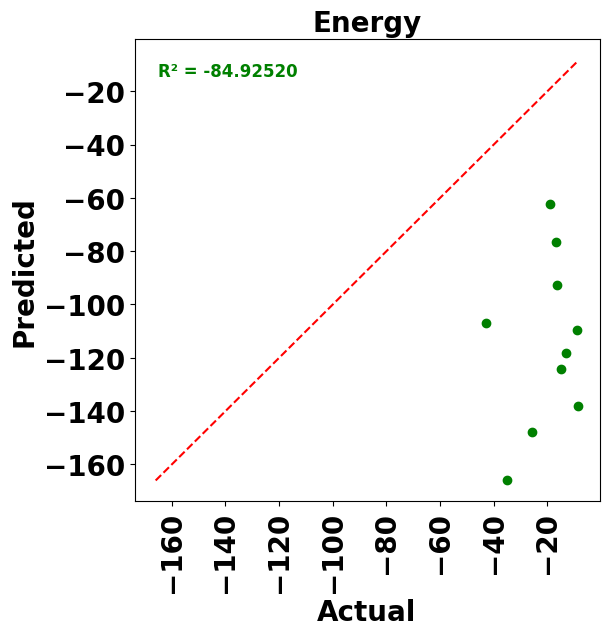

<Figure size 640x480 with 0 Axes>

In [30]:
# Function to plot R² score
def plot_r2_score(actual, pred, title="Title", suffix="500k_Faenet"):
    # save_dir = '/home/civil/phd/cez218288/scratch/Simulation/plots/'

    # Calculate R² score
    r2 = r2_score(actual, pred)

    # Create the scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, pred, label='Test', color='green')
    plt.xlabel("Actual", fontsize=20, fontweight='bold')
    plt.ylabel("Predicted", fontsize=20, fontweight='bold')
    plt.xticks(rotation=90, fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    min_val = min(min(actual), min(pred))
    max_val = max(max(actual), max(pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.title(title, fontsize=20, fontweight='bold')

    # Annotate the R² score on the plot
    plt.text(0.05, 0.95, f'R² = {r2:.5f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top', color='green')

    # Save the plot
    # filename = f"{title.replace(' ', '_')}_{suffix}.png"
    # plt.savefig(f'{save_dir}{filename}', bbox_inches='tight')
    plt.show()
    plt.clf()

# Plot and save the results for test data
# plot_r2_score(test_results['Actuals_corr_e'], test_results['Predictions_corr_e'], "Corrected Total Energy", "10k_Faenet_MP_WBM")
plot_r2_score(test_results['Actuals_e'], test_results['Predictions_e'], "Energy", "10k_Faenet_MP_WBM")
# plot_r2_score(test_results['Actuals_Fx'], test_results['Predictions_Fx'], "Fx", "500k_Faenet_trail")
# plot_r2_score(test_results['Actuals_Fy'], test_results['Predictions_Fy'], "Fy", "500k_Faenet_trail")
# plot_r2_score(test_results['Actuals_Fz'], test_results['Predictions_Fz'], "Fz", "500k_Faenet_trail")
